# Conclusion:
The stock market is really hard to predict.  I think I'll just stick with investing long-term in UPRO

In [52]:
class greg:
    def getCups(self):
        return 'cccups'
    
    def __init__(self,x,y):
        print(x + ' ' + y)
        arr = [1,2,3,4,5,6]
        self.cups = self.getCups()
        self.last = arr[-1]
        
lilGreg = greg('yup','hey')
print(lilGreg.cups)
print(lilGreg.last)

man = 'f'
for i in range(3,0-1,-1):
    man='g'
    print('j')
print(man)

yup hey
cccups
6
j
j
j
j
g


In [ ]:
# Define getting next batch of stock data

In [67]:
# ---------------Load Data-----------------
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random as random
import os as os
%matplotlib inline 

class getBatch:
    
    def getStockData(self,fileName, start, setupLength, predictLength):
        setupData = []
        file = open('stockData/' + fileName)
        fLines = file.readlines()
        end = start + setupLength + predictLength -1
        predictStartDate = fLines[start + predictLength -1].split(',')[0]
        predictEndDate = fLines[start].split(',')[0]
        high = 0
        low = 1000000
        
        # get the 'old' stock data
        for i in range(end, start-1, -1):
            line = fLines[i].strip()
            lineArray = line.split(',')
            for k in range(1,7):
                lineArray[k] = float(lineArray[k])
            x = lineArray[6]/lineArray[4]

            if(i>=(start+predictLength)):
                for j in range(1,5):
                    setupData.append(lineArray[j]*x)
                setupData.append(lineArray[5])
        
            # get the high/low of 'new' stock data (we try and predict this)
            if(i<(start + predictLength)):
                if (lineArray[2]*x > high):
                    high = lineArray[2]*x
                if (lineArray[3]*x < low):
                    low = lineArray[3]*x

        futureClose = float(fLines[start].split(',')[4])*x
        lastDayClose = setupData[-2]


        file.close()


        # ----------------------convert data to 0=>1 instead of prices
        tmpHi = 0
        tmpLow = 1000000
        tmpVolHi = 1
        tmpVolLow = 1000000000

        for i in range(0,len(setupData)): # find the His and Lows for vol and price
            if(5*(i//5)+1 == i):
                if(setupData[i] >= tmpHi):
                    tmpHi = setupData[i]
            if(5*(i//5)+2 == i):
                if(setupData[i] < tmpLow):
                    tmpLow = setupData[i]
            if(5*(i//5)+4 == i):
                if(setupData[i] >= tmpVolHi):
                    tmpVolHi = setupData[i]
                if(setupData[i] < tmpVolLow):
                    tmpVolLow = setupData[i]

                    
        for i in range(0,len(setupData)): # convert the data to values between 0 and 1
            if(5*(i//5)+4 != i):
                if(tmpHi - tmpLow == 0):
                    tmpLow = tmpHi - .10
                setupData[i] = (setupData[i] - tmpLow)/(tmpHi-tmpLow)
            if(5*(i//5)+4 == i):
                setupData[i] = (setupData[i] - tmpVolLow)/(tmpVolHi-tmpVolLow)

                    # lastDayClose, adjustedFutureClose, realfutureClose, key
        targets = [lastDayClose,(futureClose-tmpLow)/(tmpHi-tmpLow),futureClose, [(tmpHi-tmpLow), tmpLow]]
        symbolAndPredictDates = [fileName.split('.')[0], predictStartDate, predictEndDate]

    #   get only the close price ?
        justCloseData = []
        for i in range(0,len(setupData)):
            if(5*(i//5)+3==i):
                justCloseData.append(setupData[i])

        
        return setupData, targets, symbolAndPredictDates



    def fetch(self, setupLength, predictLength):
        stockFiles = os.listdir('stockData')
    
        randIndex = random.randint(0,950)
    #     randIndex = 500
        fileName = stockFiles[randIndex]
        file = open('stockData/' + fileName)
        fLines = file.readlines()
        file.close()
        start = random.randint(1, (len(fLines) - setupLength - predictLength - 1))
#         start=500
        spySetupData, spyLabels, labelDates = self.getStockData('SPY.txt',start,setupLength,predictLength)
        stockSetupData, stockTargets, labelDates = self.getStockData(fileName,start,setupLength,predictLength)
        setupData = []
    
        stockSetupData = np.asarray(stockSetupData,dtype=np.float32)
        spySetupData = np.asarray(spySetupData,dtype=np.float32)

        setupData.append(stockSetupData)
        setupData.append(spySetupData)
    
        setupData = np.reshape(setupData,(2,setupLength,5))
       
        return setupData, stockTargets, labelDates

    
    def __init__(self,setupLength,predictLength):
        self.setupData, self.targetData, self.labelData = self.fetch(setupLength,predictLength)
        self.lastDayClose = self.targetData[0]
        self.futureNormalizedClose = np.asarray([self.targetData[1]],dtype=np.float32)
        self.key = self.targetData[3]
        self.futureClose = self.targetData[2]
        self.stock = self.labelData
        
        
newBatch = getBatch(10,1)
greg = [[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5]]
# greg = np.asarray(greg)

print(newBatch.setupData)
print(newBatch.futureNormalizedClose)

print(newBatch.lastDayClose)
print(newBatch.futureClose)
print((newBatch.futureNormalizedClose)*newBatch.key[0] + newBatch.key[1])
print(newBatch.stock)

# greg=np.asarray(greg,dtype=np.float32)
# jeff[0].append(greg)
# jeff = np.reshape(jeff,(1,10,5))
# print(jeff)





[[[ 0.22821535  0.44813362  0.12033237  0.29875562  1.        ]
  [ 0.24896182  0.51037347  0.08713651  0.23236556  0.71844095]
  [ 0.22406681  0.50622445  0.01659792  0.14107884  0.47905758]
  [ 0.29875562  0.48962656  0.12448091  0.28215769  0.30541012]
  [ 0.1825722   0.41078922  0.          0.37759337  0.12739965]
  [ 0.41493776  0.68049753  0.27800748  0.46058133  0.        ]
  [ 0.51867223  0.63900459  0.13693029  0.41078922  0.17655614]
  [ 0.34439918  0.63900459  0.06639004  0.38589212  0.27370563]
  [ 0.2946054   0.64315313  0.17427303  0.48547634  0.28621292]
  [ 0.29875562  1.          0.29875562  0.61410791  0.29377544]]

 [[ 0.11464998  0.34394971  0.10031924  0.31528601  0.43086988]
  [ 0.38535032  0.49363169  0.12420376  0.22452305  1.        ]
  [ 0.10031928  0.23885354  0.          0.07802644  0.21047229]
  [ 0.27707106  0.47452173  0.08598632  0.42515916  0.39413762]
  [ 0.39331239  0.52706975  0.26910871  0.44426656  0.28990757]
  [ 0.59713387  0.7722941   0.45063734

In [100]:
# define and run our RNN

In [68]:
with tf.variable_scope("greg", reuse=True) as scope:
    setUpDaysCount = 10
    data = tf.placeholder(tf.float32, [None, setUpDaysCount,5]) #Number of examples, number of input, dimension of each input
    target = tf.placeholder(tf.float32, [1])
    
    num_hidden = 100
    cell1 = tf.nn.rnn_cell.LSTMCell(num_hidden, state_is_tuple=True)
    cell2 = tf.nn.rnn_cell.LSTMCell(num_hidden, state_is_tuple=True)
    cells=[]
    cells.append(cell1)
    cells.append(cell2)
    stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=True) # using multiple LSTM layers
    
    
    
    val, _ = tf.nn.dynamic_rnn(stacked_lstm, data, dtype=tf.float32)
    last = val[0,setUpDaysCount-1:setUpDaysCount,:] # this is the last 'slice' of the values from our neuralNet
    
    # add a readout layer to sum the results of the NN
    weight = tf.Variable(tf.truncated_normal([num_hidden,1]))
    bias = tf.Variable(tf.constant(0.1, shape=[1]))
    predictionLayer = tf.matmul(last, weight) + bias
    prediction = predictionLayer[0,:]
    
    # no classes used, just minimize the difference between actual and predicted
    loss = ((tf.abs(target - prediction)))
    optimizer = tf.train.AdamOptimizer(.01)
    train_step = optimizer.minimize(loss)
    
    
    

    # set up our session and train away!
    init_op = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init_op)

    dataArray = []
    deltaArray = []
    for i in range(0,100000):
        greg = np.asarray([[[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5]]])
#         feed1, feed2, feed3 = getBatch(setUpDaysCount,1)
        inp = getBatch(setUpDaysCount,1)
        feed1 = inp.setupData
        feed2 = inp.futureNormalizedClose
        sess.run(train_step,{data:feed1,target:feed2})
        if(i%1==0):
            predict = sess.run(prediction,{data:feed1,target:feed2})
            day11 = inp.futureClose
            delta = sess.run(loss,{data:feed1,target:feed2})
            day10 = inp.lastDayClose
            deltaArray.append(delta)
            realPredict = predict*inp.key[0] + inp.key[1]
            dataArray.append([day10,day11,realPredict])
        if(i%200 ==0):
            delta = sess.run(loss,{data: feed1,target:feed2})
            print('delta at trial ' +str(i)+': ' + str(delta))
            
    
    sess.close()

delta at trial 0: [ 9.53888035]
delta at trial 200: [ 0.03059942]
delta at trial 400: [ 0.10085434]
delta at trial 600: [ 0.0408662]
delta at trial 800: [ 0.16233677]
delta at trial 1000: [ 0.31742406]
delta at trial 1200: [ 0.01005352]
delta at trial 1400: [ 0.51776451]
delta at trial 1600: [ 0.19851157]
delta at trial 1800: [ 0.09693223]
delta at trial 2000: [ 0.18937057]
delta at trial 2200: [ 0.02009578]
delta at trial 2400: [ 0.23955876]
delta at trial 2600: [ 0.04981115]
delta at trial 2800: [ 0.14086974]
delta at trial 3000: [ 0.14357343]
delta at trial 3200: [ 0.33994722]
delta at trial 3400: [ 0.13405269]
delta at trial 3600: [ 0.41034949]
delta at trial 3800: [ 0.1516856]
delta at trial 4000: [ 0.15792397]
delta at trial 4200: [ 0.11991191]
delta at trial 4400: [ 0.06749207]
delta at trial 4600: [ 0.65730333]
delta at trial 4800: [ 0.09982899]
delta at trial 5000: [ 0.08314309]
delta at trial 5200: [ 0.21120077]
delta at trial 5400: [ 0.43475276]
delta at trial 5600: [ 0.0426

KeyboardInterrupt: 

Average delta between prediction and actual: 0.184028
[3.9787919999999994, 7.161826, array([ 4.59267759], dtype=float32)]
3223
[25.530001, 26.09, array([ 25.39734268], dtype=float32)]
[9.8, 9.82, array([ 9.4850111], dtype=float32)]
[18.02, 17.83, array([ 18.17998123], dtype=float32)]
[42.889999, 43.889999, array([ 43.26271057], dtype=float32)]
[36.48263, 36.128765, array([ 35.80170441], dtype=float32)]
[18.576539, 18.516518, array([ 18.40952492], dtype=float32)]
[50.889805, 50.120941, array([ 50.68017578], dtype=float32)]
[17.518666, 17.458645, array([ 17.64542389], dtype=float32)]
[5.979738, 6.286329, array([ 5.93451834], dtype=float32)]
[144.040355, 144.301398, array([ 142.90248108], dtype=float32)]
[60.119999, 60.029999, array([ 59.89888382], dtype=float32)]
[36.369999, 36.759998, array([ 36.46812439], dtype=float32)]
[24.371309, 24.264716, array([ 24.14204788], dtype=float32)]
[6.628658, 6.572562, array([ 6.51342916], dtype=float32)]
[37.164259, 36.707417, array([ 36.9488945], dtyp

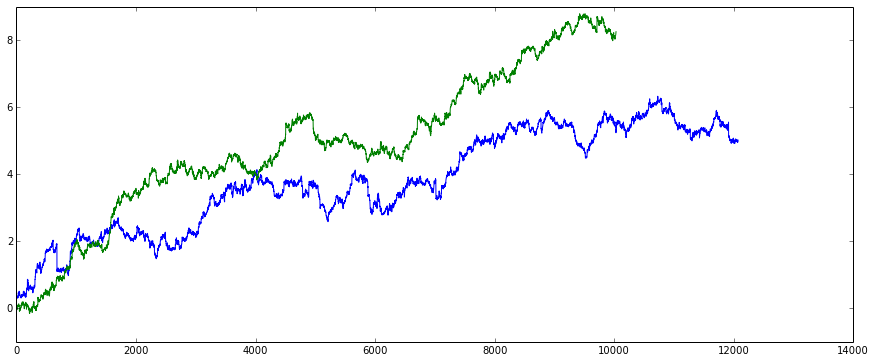

In [71]:
# print(dataArray[1000])
print('Average delta between prediction and actual: ' + str(np.mean(deltaArray[250:])))


longPlots = []
shortPlots = []
longTotal = 0
shortTotal = 0
for i in range(3223,len(dataArray)):
    print(dataArray[i])
    long = (dataArray[i][2] - dataArray[i][0])
#     if(long>100):
#         print(i)
#     print(long)
    if(long>0):
#         print(dataArray[i][1]-dataArray[i][0])
        longTotal+=(dataArray[i][1]-dataArray[i][0])/dataArray[i][1]
        greg=(dataArray[i][1]-dataArray[i][0])/dataArray[i][1]
        if(greg>.4):
            print(i)
        longPlots.append(longTotal)
    if(long<0):
        shortTotal+=(dataArray[i][0]-dataArray[i][1])/dataArray[i][1]
        shortPlots.append(shortTotal)
#     print(longTotal)
        


plt.rcParams['figure.figsize'] = (15, 6)
plt.plot(longPlots[0:])
plt.plot(shortPlots[:])
# plt.ylabel('Delta')
# plt.show()
print(len(longPlots))
print(len(shortPlots))
# plt.plot(len(dataArray[0]))

# plt.ylabel('Predicted and actual numbers (green and blue)')
# plt.plot(targetArray[len(targetArray)-100:len(day11Array)])
# plt.plot(predictArray[len(predictArray)-100:len(predictArray)])